In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostClassifier, Pool
import catboost as cb
from scrapping import df_new
from pandas.api.types import is_object_dtype
from pandas.api.types import is_datetime64_dtype
import catboost as cb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
from keras.models import Sequential
from keras.layers import Dense, LSTM
import plotly.graph_objects as go
import plotly.express as px
from statistics import median
import copy
import yfinance as yf
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2023-09-22 17:51:25.815375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 17:51:26.273544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
entered_ticket='AAPL'
df=df_new(entered_ticket)

In [4]:
df

,Date,Cash On Hand,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant, And Equipment",Long-Term Investments,Goodwill And Intangible Assets,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Total Current Liabilities,Long Term Debt,Other Non-Current Liabilities,Total Long Term Liabilities,Total Liabilities,Common Stock Net,Retained Earnings (Accumulated Deficit),Comprehensive Income,Share Holder Equity,Total Liabilities And Share Holders Equity,Revenue,Cost Of Goods Sold,Gross Profit,Research And Development Expenses,SG&A Expenses,Operating Expenses,Operating Income,Total Non-Operating Income/Expense,Pre-Tax Income,Income Taxes,Income After Taxes,Income From Continuous Operations,Net Income,EBITDA,EBIT,Basic Shares Outstanding,Shares Outstanding,Basic EPS,EPS - Earnings Per Share,Net Income/Loss,Total Depreciation And Amortization - Cash Flow,Other Non-Cash Items,Total Non-Cash Items,Change In Accounts Receivable,Change In Inventories,Change In Accounts Payable,Change In Assets/Liabilities,Total Change In Assets/Liabilities,Cash Flow From Operating Activities,"Net Change In Property, Plant, And Equipment",Net Change In Intangible Assets,Net Acquisitions/Divestitures,Net Change In Short-term Investments,Net Change In Long-Term Investments,Net Change In Investments - Total,Investing Activities - Other,Cash Flow From Investing Activities,Net Long-Term Debt,Net Current Debt,Debt Issuance/Retirement Net - Total,Net Common Equity Issued/Repurchased,Net Total Equity Issued/Repurchased,Total Common And Preferred Stock Dividends Paid,Financial Activities - Other,Cash Flow From Financial Activities,Net Cash Flow,Stock-Based Compensation,Common Stock Dividends Paid,FCF,Discount_rate,Discount_factor,DCF,Grow_rate,CDCF,Market_value,Intrinsic Value
0,2023-06-30,62482.00,39186.00,7351.00,13640.00,122659.00,43550.00,104061.00,0.00,64768.00,212379.00,335038.00,124963.00,98071.00,51730.00,149801.00,274764.00,70667.00,1408.00,-11801.00,60274.00,335038.00,81797.00,45384.00,36413.00,7442.00,5973.00,13415.00,22998.00,-265.00,22733.00,2852.00,19881.00,19881.00,19881.00,26050.00,22998.00,15697.61,15775.02,1.27,1.26,19881.00,3052.00,2698.00,5750.00,-1987.00,-22.00,3974.00,-1216.00,749.00,26380.00,-2093.00,0.00,0.00,3036.00,0.00,3036.00,-506.00,437.00,-2272.00,1989.00,-283.00,-17478.00,-17478.00,-3849.00,-2438.00,-24048.00,2769.00,2617.00,-3849.00,24287.00,0.05,0.48,11681.18,-0.05,771391.48,949412.56,60.18
1,2023-03-31,55872.00,35899.00,7482.00,13660.00,112913.00,43398.00,110461.00,0.00,65388.00,219247.00,332160.00,120075.00,97041.00,52886.00,149927.00,270002.00,69568.00,4336.00,-11746.00,62158.00,332160.00,94836.00,52860.00,41976.00,7457.00,6201.00,13658.00,28318.00,64.00,28382.00,4222.00,24160.00,24160.00,24160.00,31216.00,28318.00,15787.15,15847.05,1.53,1.52,24160.00,2898.00,1271.00,4169.00,5321.00,-741.00,-14689.00,10340.00,231.00,28560.00,-2916.00,0.00,0.00,5341.00,0.00,5341.00,-106.00,2319.00,-2250.00,254.00,-1996.00,-19594.00,-19594.00,-3650.00,-484.00,-25724.00,5155.00,2686.00,-3650.00,25644.00,0.05,0.52,13270.01,-0.15,759710.29,841125.52,53.08
2,2022-12-31,51355.00,54180.00,6820.00,16422.00,128777.00,42951.00,114095.00,0.00,60924.00,217970.00,346747.00,137286.00,99627.00,53107.00,152734.00,290020.00,66399.00,3240.00,-12912.00,56727.00,346747.00,117154.00,66822.00,50332.00,7709.00,6607.00,14316.00,36016.00,-393.00,35623.00,5625.00,29998.00,29998.00,29998.00,38932.00,36016.00,15892.72,15955.72,1.89,1.88,29998.00,2916.00,2588.00,5504.00,4275.00,-1807.00,-6075.00,2110.00,-1497.00,34005.00,-3787.00,0.00,0.00,2483.00,0.00,2483.00,-141.00,-1445.00,-1401.00,-8214.00,-9615.00,-19475.00,-19475.00,-3768.00,-2705.00,-35563.00,-3003.00,2905.00,-3768.00,30218.00,0.04,0.56,17070.63,0.45,746440.28,707633.62,44.35
3,2022-09-30,48304.00,60932.00,4946.00,21223.00,135405.00,42117.00,120805.00,0.00,54428.00,217350.00,352755.00,153982.00,98959.00,49142.00,148101.00,302083.00,64849.00,-3068.00,-11109.00,50672.00,352755.00,90146.0

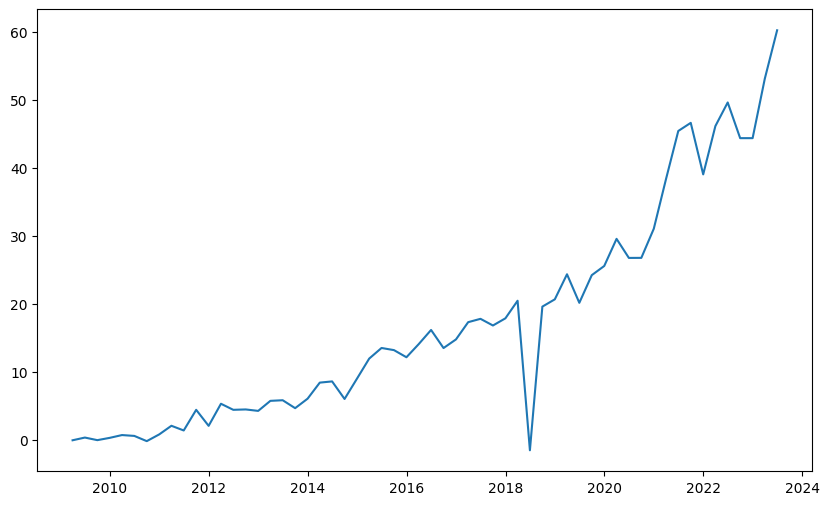

In [5]:
# z = np.polyfit(df['Intrinsic Value'], df.index, 1)
# p = np.poly1d(z)
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Intrinsic Value'])
# plt.plot(df['Date'], p(df.index),  "r--")
plt.show()

In [6]:
df_test=df.copy()

In [7]:
data=df_test['FCF'][::-1]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

train_data=scaled_data
# train_data = scaled_data[:int(0.8 * len(df_test))]
# test_data = scaled_data[int(0.8 * len(df_test)):]

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 4
X_train, y_train = create_sequences(train_data, seq_length)
# X_test, y_test = create_sequences(test_data, seq_length)

X_test = scaled_data[-4-seq_length:-4]
X_test = X_test.reshape(1, seq_length, -1)

model = Sequential([
    LSTM(4, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(4),
    Dense(1)
])

model.summary()

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=1000)

2023-09-22 17:51:31.058058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:51:31.069151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:51:31.069209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:51:31.070576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:51:31.070633: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 4)                 144       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 245 (980.00 Byte)
Trainable params: 245 (980.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000


2023-09-22 17:51:34.172554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-22 17:51:34.261886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-22 17:51:34.281052: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4d3362bdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 17:51:34.281078: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-09-22 17:51:34.285027: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-22 17:51:34.365641: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

2/2 [==============================] - 2s 10ms/step - loss: 0.1524
Epoch 2/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1483
Epoch 3/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.1447
Epoch 4/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1409
Epoch 5/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.1372
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1338
Epoch 7/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1301
Epoch 8/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1266
Epoch 9/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1231
Epoch 10/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1197
Epoch 11/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1162
Epoch 12/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1128
Epoch 13/1000
2/2 [==============================] - 0s 6ms/s

In [8]:
next_fcf=scaler.inverse_transform(model.predict(X_test).reshape(-1, 1))
next_fcf

1/1 [==============================] - 0s 369ms/step


array([[20593.52]], dtype=float32)

In [9]:
next_disc_rate=df['Discount_rate'].loc[0]
next_disc_factor=1 / ((1 + next_disc_rate/4) ** ((len(df))))
next_dcf=next_fcf*next_disc_factor
next_cdcf=df.loc[0, 'CDCF']+next_dcf
next_grow_rate=df['Grow_rate'].loc[0]
next_market_value= (next_fcf/(next_disc_rate/4-next_grow_rate))*next_disc_factor+next_cdcf
next_shares_outstanding=df['Shares Outstanding'].loc[0]
next_intrinsic_value=next_market_value/next_shares_outstanding
next_intrinsic_value



array([[59.09625]], dtype=float32)